# Segmenting and Clustering Neighborhoods in Oslo

## Preliminaries - Import packages

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import datasets

import folium # map rendering library

# use the inline backend to generate the plots within the browser
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

## Section 1 - Create a data frame with Oslo's neighborhoods and their locations

Load oslo neighborhoods from xlsx file

In [2]:
df_oslo = pd.read_excel('oslo_hoods.xlsx')
print(df_oslo.shape)
df_oslo.head()

(157, 2)


,Borough,Neighborhood
0,Alna,Alfaset
1,Alna,Alnabru
2,Alna,Ellingsrud
3,Alna,Furuset
4,Alna,Haugerud


Find the coordinates for all neighborhoods in oslo (skip this step if you already have build the csv file)

In [3]:

df_oslo['Latitude'] = ""
df_oslo['Longitude'] = ""
geolocator = Nominatim(user_agent="ny_explorer")

for row in range(df_oslo.shape[0]):
    neighborhood = df_oslo.loc[row,'Neighborhood']
    address = '{}, {}, {}'.format(neighborhood, 'Oslo', 'Norway')
    location = geolocator.geocode(address)
    try:
        df_oslo.loc[row,'Longitude'] = location.longitude
        df_oslo.loc[row,'Latitude'] = location.latitude
    except:
        print("An exception occured in row {}.".format(row))

df_oslo.head()

An exception occured in row 29.


,Borough,Neighborhood,Latitude,Longitude
0,Alna,Alfaset,59.9319,10.8535
1,Alna,Alnabru,59.9288,10.8377
2,Alna,Ellingsrud,59.9342,10.9209
3,Alna,Furuset,59.9411,10.8964
4,Alna,Haugerud,59.9221,10.8545


Save data frame to csv for future usage so that we dont have to run the above code again

In [4]:
df_oslo.to_csv('oslo_coordinates.csv',index=False,header=True)

Load the coordinates file (run this step only if you have already build the csv file)

In [5]:
df = pd.read_csv('oslo_coordinates.csv')
print(df.shape)
df.head()

(157, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Alna,Alfaset,59.931928,10.853528
1,Alna,Alnabru,59.928786,10.837697
2,Alna,Ellingsrud,59.934191,10.920897
3,Alna,Furuset,59.941067,10.896399
4,Alna,Haugerud,59.922116,10.854522


There is one neighborhood that the geolocator couldn't find the coordinates. Let's drop it and display the shape and head of the data frame.

In [6]:
df.drop(29,inplace=True)
df.reset_index(drop=True)
print(df.shape)
df.head()


(156, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Alna,Alfaset,59.931928,10.853528
1,Alna,Alnabru,59.928786,10.837697
2,Alna,Ellingsrud,59.934191,10.920897
3,Alna,Furuset,59.941067,10.896399
4,Alna,Haugerud,59.922116,10.854522


Let's create a map of oslo displaying the neighborhoods to be analysed. Start by storing the location of Oslo. Then, use folium to plot.

In [7]:
#get the coordinates for Oslo
address = 'Oslo, Norway'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Oslo are {}, {}.'.format(latitude, longitude))

# create map of Oslo using latitude and longitude values
map_oslo = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_oslo)  
    
map_oslo  

The geograpical coordinate of Oslo are 59.9133301, 10.7389701.


## Section 2 - Get the venues using Foursquare API

Define Foursquare Credentials and Version

In [8]:
client_id = '3VN3BW55EFHN2PZL3QCEGFNUXIEYKLNXUQ5PZV5J2NAC3SL5' # your Foursquare ID
client_secret = 'PKDIFCZGAY1QUPUKOTUQJAGHRUL23AVXPLLVBFMNSPE4CEY5' # your Foursquare Secret
version = '20180605' # Foursquare API version
limit = 200 # A default Foursquare API limit value
radius = 500

Define a function that finds the venues for every neighborhood and writes everything in "nearby_venues" data frame.

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
# define the inputs and call the function
input1 = df['Neighborhood'].values.tolist()
input2 = df['Latitude'].values.tolist()
input3 = df['Longitude'].values.tolist()

oslo_venues = getNearbyVenues(input1, input2, input3)

Alfaset
Alnabru
Ellingsrud
Furuset
Haugerud
Hellerud
Karihaugen
Lindeberg
Teisen
Trosterud
Tveita
Bjerke
Bredtvet
Linderud
Lofthus
Refstad
Risløkka
Stig
Tonsenhagen
Veitvet
Økern
Årvoll
Aker Brygge
Briskeby
Bygdøy
Elisenberg
Filipstad
Frogner
Gimle
Homansbyen
Majorstuen
Ruseløkka
Skarpsno
Skillebekk
Tjuvholmen
Uranienborg
Arctanderbyen
Ekebergskrenten
Enerhaugen
Ensjø
Etterstad
Galgeberg
Gamlebyen
Grønland
Helsfyr
Jordal
Kampen
Kværner
Kværnerbyen
Sørenga
Tøyen
Valle
Vålerenga
Ammerud
Flaen
Grorud
Kalbakken
Nordtvet
Romsås
Rødtvet
Carl Berner
Grünerløkka
Hasle
Hovin
Keyserløkka
Løren
Rodeløkka
Rosenhoff
Sinsen
Sofienberg
Berg
Blindern
Brekke
Disen
Gaustad
Grefsen 
Kjelsås
Korsvoll
Kringsjå
Nordberg
Nydalen
Sogn
Storo
Tåsen
Ullevål
Ullevål Hageby
Åsen
Bekkelaget
Bekkelagshøgda
Brattlikollen
Ekeberg
Jomfrubråten
Kastellet
Lambertseter
Ljabru
Ljan
Munkerud
Nordstrand
Ryen
Simensbråten
Bjølsen
Iladalen
Sagene
Sandaker
Torshov
Bjørvika
Pipervika
Vaterland
Vika
Adamstuen
Bislett
Bolteløkka
F

Display the number of venues and the number of unique categories in the data frame

In [11]:
print('There are total {} venues.'.format(oslo_venues.shape[0]))
print('There are {} uniques categories.'.format(len(oslo_venues['Venue Category'].unique())))

oslo_venues.head()

There are total 2402 venues.
There are 227 uniques categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alfaset,59.931928,10.853528,Stoff Og Stil,59.929213,10.846513,Arts & Crafts Store
1,Alfaset,59.931928,10.853528,Kvik,59.928116,10.849347,Furniture / Home Store
2,Alfaset,59.931928,10.853528,Fargerike Alnabru,59.927642,10.851513,Furniture / Home Store
3,Alnabru,59.928786,10.837697,Stoff Og Stil,59.929213,10.846513,Arts & Crafts Store
4,Alnabru,59.928786,10.837697,Alna stasjon,59.931997,10.834962,Train Station


Venue categories like train stations and bus stations aren't really venues in the broader sense of a venues. So, let's remove them from the analysis. First, create a list of all unique categories and a data frame for reference. Then, create a set of categories to remove.

In [12]:
categories = oslo_venues['Venue Category'].unique().tolist()
categories_ref = pd.DataFrame(categories)
categories_ref.columns = ['Categories'] 
categories_ref

,Categories
0,Arts & Crafts Store
1,Furniture / Home Store
2,Train Station
3,Hot Dog Joint
4,Bus Station
5,Bed & Breakfast
6,Metro Station
7,Gym / Fitness Center
8,Grocery Store
9,Warehouse Store


Remove venues that contain the word 'Station' or 'Stop'

In [13]:
remove_venues = [i for i in categories if any(s in i for s in('Station', 'Stop'))]
remove_venues

['Train Station',
 'Bus Station',
 'Metro Station',
 'Bus Stop',
 'Light Rail Station',
 'Tram Station',
 'Gas Station']

Lets create a set with categories related to restaurants for future usage. There are different ways to do this, like picking out venues that contain key words like pizza, cuisine, restaurant etc. Here we did this manually by checking the reference data frame.

In [14]:
restaurant_venues = list(categories[i] for i in [3,10,20,23,24,29,30,31,37,43,46,47,48,49,50,51,53,54,55,58,62,63,64,65,68,69,70,71,75,77,78,79,81,82,83,84,85,86,87,89,90,91,96,98,102,105,106,108,109,113,114,117,118,121,122,124,125,129,131,133,137,142,145,147,155,157,159,164,165,166,168,173,200,207,209,217])
print('From the {} unique venues in Oslo {} of them can be classified as food and drink providers.'.format(len(categories),len(restaurant_venues)))

From the 227 unique venues in Oslo 76 of them can be classified as food and drink providers.


Lets remove the transportation venues from the oslo_venues data frame

In [15]:
oslo_venues_clean = oslo_venues.drop(oslo_venues[oslo_venues['Venue Category'].isin(remove_venues)].index)
print(oslo_venues_clean.shape)
oslo_venues_clean.head()

(2226, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alfaset,59.931928,10.853528,Stoff Og Stil,59.929213,10.846513,Arts & Crafts Store
1,Alfaset,59.931928,10.853528,Kvik,59.928116,10.849347,Furniture / Home Store
2,Alfaset,59.931928,10.853528,Fargerike Alnabru,59.927642,10.851513,Furniture / Home Store
3,Alnabru,59.928786,10.837697,Stoff Og Stil,59.929213,10.846513,Arts & Crafts Store
5,Alnabru,59.928786,10.837697,Lennarts Kioskdrift,59.929131,10.846209,Hot Dog Joint


Lets visualize how many venues are in each borough, and check whether we have reached the limit of 100 of a neighborhood.

In [16]:
oslo_venues_clean
oslo_freq = oslo_venues_clean.groupby('Neighborhood').count()
oslo_freq = oslo_freq.loc[:, oslo_freq.columns == 'Venue']
oslo_freq.columns = ['Frequency Venues']
#oslo_venues_freq[oslo_venues_freq['Frequency']>=100]
oslo_freq.head()

,Frequency Venues
Neighborhood,
Abildsø,3
Adamstuen,13
Aker Brygge,35
Alfaset,3
Alnabru,2


In [17]:
oslo_freq2 = df[['Borough','Neighborhood']]
oslo_freq2 = oslo_freq2.join(oslo_freq, on='Neighborhood')
oslo_freq2 = oslo_freq2.groupby('Borough').sum()
#oslo_freq2 = oslo_freq2.loc[:, oslo_freq2.columns == 'Frequency']
oslo_freq2_sorted = oslo_freq2.sort_values('Frequency Venues',ascending=False)
oslo_freq2_sorted

,Frequency Venues
Borough,
Frogner,540.0
Gamle Oslo,330.0
Grünerløkka,268.0
Sentrum,257.0
St. Hanshaugen,203.0
Nordre Aker,143.0
Sagene,114.0
Nordstrand,57.0
Grorud,54.0


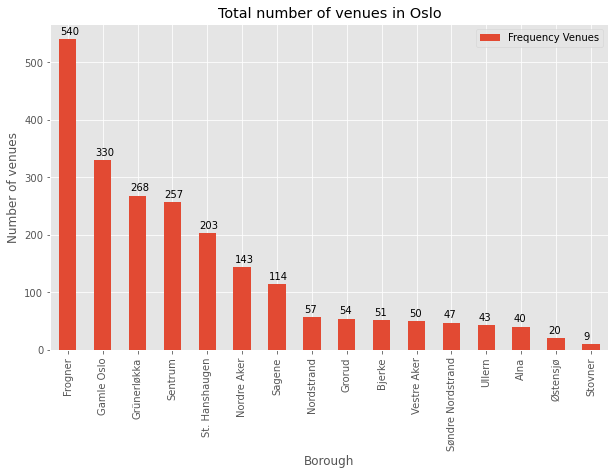

In [18]:
ax = oslo_freq2_sorted.plot(kind='bar', figsize=(10, 6))

plt.title("Total number of venues in Oslo")
plt.xlabel("Borough")
plt.ylabel("Number of venues")

perc = []
for i in ax.patches:    perc.append(i.get_height())
    
for index, name in enumerate(ax.patches):
    # get_x pulls left or right; get_height pushes up or down
    ax.text(name.get_x()+.03, name.get_height()+5, \
            str(int(perc[index])), fontsize=10, va='bottom', ha='left')
    

plt.show()


Now lets create a new variable "restaurant" that will take the value of 1 if a venue belongs to the restaurant_venues list and 0 otherwise. We shall use this variable to compute the frequency of restaurant related venues in each borough in the city of Oslo.

In [19]:
oslo_venues_clean['restaurant'] = 0
rows = oslo_venues_clean[oslo_venues_clean['Venue Category'].isin(restaurant_venues)].index.tolist()
oslo_venues_clean.loc[rows,'restaurant'] = 1
oslo_venues_clean.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,restaurant
0,Alfaset,59.931928,10.853528,Stoff Og Stil,59.929213,10.846513,Arts & Crafts Store,0
1,Alfaset,59.931928,10.853528,Kvik,59.928116,10.849347,Furniture / Home Store,0
2,Alfaset,59.931928,10.853528,Fargerike Alnabru,59.927642,10.851513,Furniture / Home Store,0
3,Alnabru,59.928786,10.837697,Stoff Og Stil,59.929213,10.846513,Arts & Crafts Store,0
5,Alnabru,59.928786,10.837697,Lennarts Kioskdrift,59.929131,10.846209,Hot Dog Joint,1


In [20]:
#create a data frame that computes the frequency of restaurants
oslo_freq_restaurant = oslo_venues_clean.groupby('Neighborhood').sum()
oslo_freq_restaurant = oslo_freq_restaurant.loc[:, oslo_freq_restaurant.columns == 'restaurant']
oslo_freq_restaurant.columns = ['Frequency Restaurants']

#merge the restaurant frequency data frame with the frequency data frame and the boroughs one
oslo_freq3 = df[['Borough','Neighborhood']]
oslo_freq3 = oslo_freq3.join(oslo_freq, on='Neighborhood')
oslo_freq3 = oslo_freq3.join(oslo_freq_restaurant, on='Neighborhood')
oslo_freq3 = oslo_freq3.groupby('Borough').sum()
oslo_freq3.head()

oslo_freq3_sorted = oslo_freq3.sort_values('Frequency Venues',ascending=False)
oslo_freq3_sorted

oslo_freq3_sorted['Percentage of Restaurants'] = round(100*(oslo_freq3_sorted['Frequency Restaurants']/oslo_freq3_sorted['Frequency Venues']),2)
oslo_freq3_sorted.head()

,Frequency Venues,Frequency Restaurants,Percentage of Restaurants
Borough,,,
Frogner,540.0,235.0,43.52
Gamle Oslo,330.0,132.0,40.00
Grünerløkka,268.0,108.0,40.30
Sentrum,257.0,107.0,41.63
St. Hanshaugen,203.0,91.0,44.83


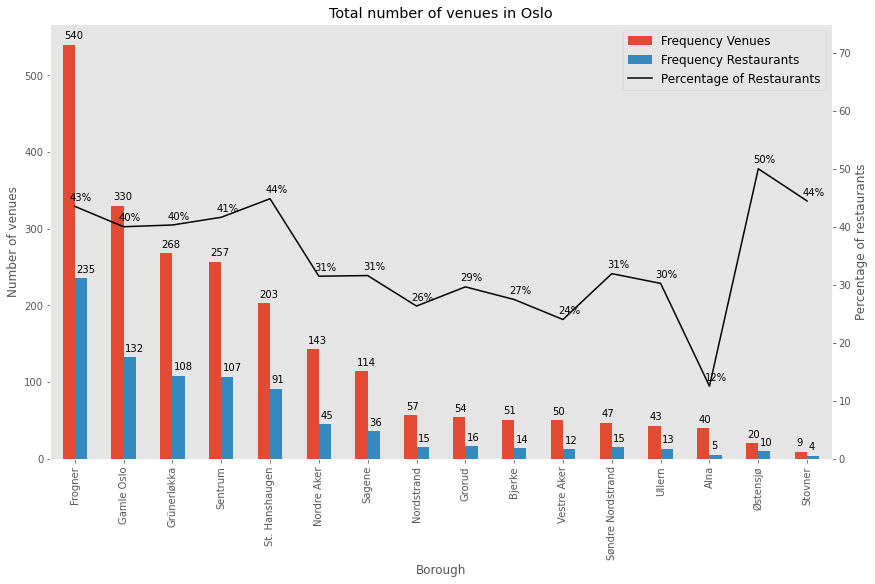

In [21]:
fig = plt.figure()

ax1 = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax1.twinx() # Create another axes that shares the same x-axis as ax.


oslo_freq3_sorted[['Frequency Venues','Frequency Restaurants']].plot(kind='bar', figsize=(14, 8), ax=ax1)
oslo_freq3_sorted[['Percentage of Restaurants']].plot(kind='line', ax=ax2, color='black')

plt.title("Total number of venues in Oslo")
ax1.set_xlabel("Borough")
ax1.set_ylabel("Number of venues")
ax2.set_ylabel('Percentage of restaurants')

perc = []
for i in ax1.patches:    perc.append(i.get_height())   
for index, name in enumerate(ax1.patches):
    # get_x pulls left or right; get_height pushes up or down
    ax1.text(name.get_x()+.03, name.get_height()+5, \
            str(int(perc[index])), fontsize=10, va='bottom', ha='left')
    
for index, name in enumerate(oslo_freq3_sorted[['Percentage of Restaurants']].index):
    ax2.text(index-0.1,oslo_freq3_sorted.iloc[index,2]+1 ,str(int(oslo_freq3_sorted.iloc[index,2]))+'%')  
    
ax1.get_legend().remove()
ax2.get_legend().remove()
handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
ax1.legend(handles, labels, fontsize=12)

ax1.grid(False)
ax2.grid(False)
ax2.set_ylim([0,75])
#ax1.set_facecolor('white')
#ax2.set_facecolor('white')
#ax1.axes.spines["bottom"].set_color("black")
#ax2.axes.spines["bottom"].set_color("black")


plt.show()


In [22]:
oslo_freq

,Frequency Venues
Neighborhood,
Abildsø,3
Adamstuen,13
Aker Brygge,35
Alfaset,3
Alnabru,2
Ammerud,4
Arctanderbyen,1
Bekkelaget,2
Berg,1


<ipython-input-23-84cce98823d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oslo_freq4['VenueLevel'][oslo_freq4['Frequency Venues']<10] = 'Low'
<ipython-input-23-84cce98823d4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oslo_freq4['VenueLevel'][oslo_freq4['Frequency Venues']>50] = 'High'


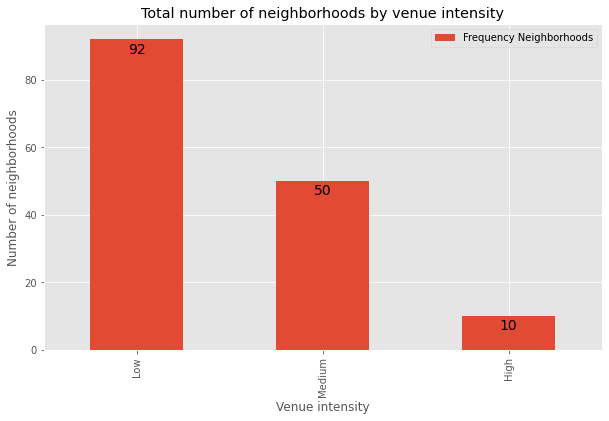

In [23]:
oslo_freq.head()
oslo_freq4 = oslo_freq
oslo_freq4['VenueLevel']= "Medium"
oslo_freq4['VenueLevel'][oslo_freq4['Frequency Venues']<10] = 'Low'
oslo_freq4['VenueLevel'][oslo_freq4['Frequency Venues']>50] = 'High'

oslo_freq5 = oslo_freq4.groupby('VenueLevel').count()
oslo_freq5.columns=['Frequency Neighborhoods']
oslo_freq5_sorted = oslo_freq5.sort_values('Frequency Neighborhoods',ascending=False)
ax = oslo_freq5_sorted.plot(kind='bar', figsize=(10, 6))

plt.title("Total number of neighborhoods by venue intensity")
plt.xlabel("Venue intensity")
plt.ylabel("Number of neighborhoods")

perc = []
for i in ax.patches:    perc.append(i.get_height())
    
for index, name in enumerate(ax.patches):
    # get_x pulls left or right; get_height pushes up or down
    ax.text(name.get_x()+.2, name.get_height()-5, \
            str(int(perc[index])), fontsize=14, va='bottom', ha='left')
    

plt.show()

## Section 3 - Analyse the neighborhoods

Let's do a one hot encoding to the venue categories and include the neighborhood name in the new data frame oslo_onehot.

In [24]:
# one hot encoding
oslo_onehot = pd.get_dummies(oslo_venues_clean[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
oslo_onehot['Neighborhood'] = oslo_venues_clean['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [oslo_onehot.columns[-1]] + list(oslo_onehot.columns[:-1])
oslo_onehot = oslo_onehot[fixed_columns]
print(oslo_onehot.shape)
oslo_onehot.head()

(2226, 221)


,Neighborhood,Advertising Agency,Alternative Healer,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boarding House,Bookstore,Botanical Garden,Bowling Alley,Brasserie,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Business Service,Butcher,Café,Camera Store,Campground,Candy Store,Cantonese Restaurant,Castle,Champagne Bar,Chinese Restaurant,Chiropractor,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Administrative Building,College Cafeteria,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,Health Food Store,History Museum,Hockey Arena,Hockey Field,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Lawyer,Liquor Store,Lounge,Market,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Night Market,Nightclub,Noodle House,North Indian Restaurant,Nursery School,Office,Opera House,Optical Shop,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Port,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Ski Area,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,Alfaset,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Alfaset,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Alfaset,0,0,0,0,0,0,0,0

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [25]:
oslo_grouped = oslo_onehot.groupby('Neighborhood').mean().reset_index()
#oslo_grouped_clean = oslo_grouped.drop(columns = remove_venues)
print(oslo_grouped.shape)
oslo_grouped.head()

(152, 221)


,Neighborhood,Advertising Agency,Alternative Healer,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boarding House,Bookstore,Botanical Garden,Bowling Alley,Brasserie,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Business Service,Butcher,Café,Camera Store,Campground,Candy Store,Cantonese Restaurant,Castle,Champagne Bar,Chinese Restaurant,Chiropractor,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Administrative Building,College Cafeteria,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,Health Food Store,History Museum,Hockey Arena,Hockey Field,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Lawyer,Liquor Store,Lounge,Market,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Night Market,Nightclub,Noodle House,North Indian Restaurant,Nursery School,Office,Opera House,Optical Shop,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Port,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Ski Area,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,Abildsø,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,

Let's put the top 10 venues in each neighborhood in a new data frame. First, let's write a function to sort the venues in descending order.

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    output = row_categories_sorted[row_categories_sorted>0].index.values[0:num_top_venues]
    while len(output)<num_top_venues:
        output = np.append(output, 'NA')
        
    return output

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [27]:
num_top_venues = 10

indicators = ['st','nd','rd']
columns = ['Neighborhood']

for index in range(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(index+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(index+1))
        
# create a new dataframe
oslo_venues_sorted = pd.DataFrame(columns=columns) 
oslo_venues_sorted['Neighborhood'] = oslo_grouped['Neighborhood']

for index in range(oslo_grouped.shape[0]):
    oslo_venues_sorted.iloc[index,1:] = return_most_common_venues(oslo_grouped.iloc[index,:], num_top_venues)

print(oslo_venues_sorted.shape)
oslo_venues_sorted.head(5)


(152, 11)


,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abildsø,Soccer Field,Farm,Grocery Store,NA,NA,NA,NA,NA,NA,NA
1,Adamstuen,Bakery,Coffee Shop,Park,Deli / Bodega,Middle Eastern Restaurant,French Restaurant,Skating Rink,Café,Japanese Restaurant,Gym / Fitness Center
2,Aker Brygge,Hotel,Seafood Restaurant,Scandinavian Restaurant,Burger Joint,Bistro,Café,Cantonese Restaurant,Restaurant,Cocktail Bar,Coffee Shop
3,Alfaset,Furniture / Home Store,Arts & Crafts Store,NA,NA,NA,NA,NA,NA,NA,NA
4,Alnabru,Hot Dog Joint,Arts & Crafts Store,NA,NA,NA,NA,NA,NA,NA,NA


Cluster neighborhoods using k-means algorithm

In [28]:
# set number of clusters
kclusters = 3
oslo_grouped_clustering = oslo_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(oslo_grouped_clustering)
# check cluster labels generated for each row in the dataframe
print(kmeans.labels_)
# add clustering labels
oslo_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

[0 2 2 2 2 0 1 2 2 2 2 2 2 0 0 2 2 0 2 2 1 2 2 2 2 2 2 0 2 0 2 2 2 2 2 0 2
 2 2 2 2 2 0 0 2 2 2 0 2 0 2 2 0 2 0 2 2 1 2 1 2 2 2 0 2 2 1 2 0 0 2 1 0 2
 2 0 1 0 1 0 2 1 0 2 2 2 2 0 0 1 0 0 2 0 2 2 0 2 2 0 2 0 0 2 0 2 0 2 2 0 0
 2 2 2 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 0 2 2 2 2 2 2 0 2 2 2 2
 2 0 0 0]


Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [29]:
# merge oslo_grouped with df to add latitude/longitude for each neighborhood
oslo_merged = oslo_venues_sorted
oslo_merged = oslo_merged.join(df.set_index('Neighborhood'), on='Neighborhood')
column_names = ['Borough','Neighborhood','Latitude','Longitude','Cluster Labels']
for index in range(num_top_venues):
    try:
        column_names.append('{}{} Most Common Venue'.format(index+1, indicators[ind]))
    except:
        column_names.append('{}th Most Common Venue'.format(index+1))
        
oslo_merged = oslo_merged.reindex(columns=column_names)

oslo_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Østensjø,Abildsø,59.886331,10.819720,0,Soccer Field,Farm,Grocery Store,NA,NA,NA,NA,NA,NA,NA
1,St. Hanshaugen,Adamstuen,59.932728,10.734403,2,Bakery,Coffee Shop,Park,Deli / Bodega,Middle Eastern Restaurant,French Restaurant,Skating Rink,Café,Japanese Restaurant,Gym / Fitness Center
2,Frogner,Aker Brygge,59.909928,10.725042,2,Hotel,Seafood Restaurant,Scandinavian Restaurant,Burger Joint,Bistro,Café,Cantonese Restaurant,Restaurant,Cocktail Bar,Coffee Shop
3,Alna,Alfaset,59.931928,10.853528,2,Furniture / Home Store,Arts & Crafts Store,NA,NA,NA,NA,NA,NA,NA,NA
4,Alna,Alnabru,59.928786,10.837697,2,Hot Dog Joint,Arts & Crafts Store,NA,NA,NA,NA,NA,NA,NA,NA


Visualise resulting clusters

In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(oslo_merged['Latitude'], oslo_merged['Longitude'], oslo_merged['Neighborhood'], oslo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [31]:
dict_clusters = {}
for i in range(kclusters):
    dict_clusters[i] = oslo_merged.loc[oslo_merged['Cluster Labels'] == i, oslo_merged.columns[[1] + list(range(5, oslo_merged.shape[1]))]]
    print('Cluster {} contains {} elements.'.format(i,dict_clusters[i].shape[0]))

Cluster 0 contains 44 elements.
Cluster 1 contains 10 elements.
Cluster 2 contains 98 elements.


In [32]:
#0 - red; 1 - purple; 2 - blue; 3 - green; 4 - orange
dict_clusters[1]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Arctanderbyen,Grocery Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
20,Brekke,Grocery Store,Bathing Area,NA,NA,NA,NA,NA,NA,NA,NA
57,Hovseter,Grocery Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
59,Høybråten,Grocery Store,Factory,NA,NA,NA,NA,NA,NA,NA,NA
66,Kastellet,Grocery Store,Beach,NA,NA,NA,NA,NA,NA,NA,NA
71,Kringsjå,Grocery Store,Lake,NA,NA,NA,NA,NA,NA,NA,NA
76,Lindeberg,Grocery Store,Motorcycle Shop,Furniture / Home Store,NA,NA,NA,NA,NA,NA,NA
78,Ljabru,Grocery Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
81,Lysejordet,Grocery Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
89,Nordberg,Grocery Store,NA,NA,NA,NA,NA,NA,NA,NA,NA


Find the frequence of the 1st most common venue in each cluster

In [33]:
def freq_most_common_venues(most_common_venues):
    most_common_venues_unq = most_common_venues.unique()
    most_common_venues_freq = []
    output = []
    for item in most_common_venues_unq:
        #most_common_venues_freq.append(sum(most_common_venues == item))
        output.append([item,sum(most_common_venues == item)])
        
    return output#(most_common_venues_unq.tolist(), most_common_venues_freq)

dict_freq={}
for i in range(kclusters):
    temp = dict_clusters[i]['1th Most Common Venue']
    temp2 = freq_most_common_venues(temp)
    dict_freq[i] = pd.DataFrame(temp2, columns = ['Cluster'+str(i)+'_MCV','Freq'+str(i)])

Plot a horizontal plot for each cluster display the frequency of the most common venues

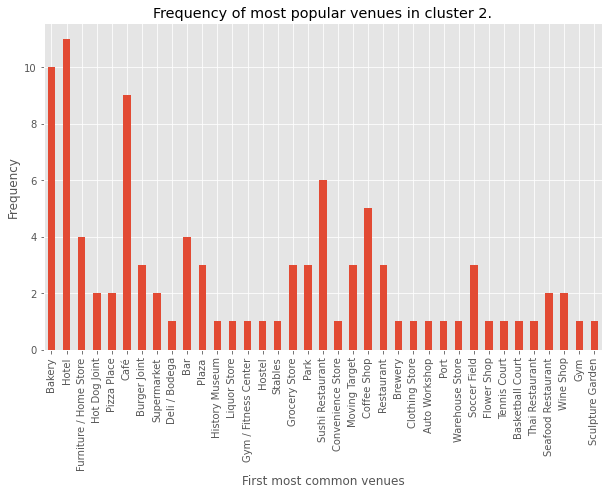

In [34]:
i = 2 #cluster to be plotted
df_temp = dict_freq[i].set_index('Cluster'+str(i)+'_MCV')


df_temp.plot(kind='bar', figsize=(10, 6))
#oslo_freq3_sorted[['Percentage of Restaurants']].plot(kind='line', ax=ax1, color='black')

plt.title("Frequency of most popular venues in cluster "+str(i)+'.')
plt.xlabel("First most common venues")
plt.ylabel("Frequency")
plt.legend().remove()


Find the restaurant penetration in each cluster. Restaurant penetration is defined as the percentage of restaurant like venues from the top 10 most common venues in each cluster.

In [35]:
for j in range(3):
    df_temp = dict_clusters[j]#.set_index('Cluster'+str(i)+'_MCV')
    df_temp['restaurant'] = 0
    df_temp['venues'] = 0
    for i in range(df_temp.shape[0]):
        df_temp.iloc[i,11] = df_temp.iloc[i,1:11].isin(restaurant_venues).sum()
        df_temp.iloc[i,12] = 10-df_temp.iloc[i,1:11].isin(['NA']).sum()
        
    temp = df_temp[['restaurant','venues']].sum()  
    print('In cluster {} out of the {} venues {} are restaurants. The restaurant penetration is {}%.'.format(j,temp[1],temp[0],round(temp[0]/temp[1]*100,2))) 
#print('The restaurant penetration in cluster '+str(ii)+' is '+str(round(temp[0]/temp[1]*100,2))+'%.')

In cluster 0 out of the 213 venues 62 are restaurants. The restaurant penetration is 29.11%.
In cluster 1 out of the 16 venues 0 are restaurants. The restaurant penetration is 0.0%.
In cluster 2 out of the 687 venues 258 are restaurants. The restaurant penetration is 37.55%.
